In [1]:
import torch
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import os

# -------------------- Project paths --------------------
# Notebook is in: fruit_veg_classifier/notebooks/
base_dir = os.path.dirname(os.getcwd())  # fruit_veg_classifier/
train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")

# -------------------- Image preprocessing --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------- Load dataset --------------------

# --- STAGE 1: The Parent (Fruit vs Veg) ---
# Reads 'train/fruit' and 'train/vegetable'
train_dataset_stage1 = ImageFolder(train_dir, transform=transform)
test_dataset_stage1  = ImageFolder(test_dir, transform=transform)

train_loader_stage1 = DataLoader(train_dataset_stage1, batch_size=32, shuffle=False)
test_loader_stage1  = DataLoader(test_dataset_stage1, batch_size=32, shuffle=False)

print("Stage 1 classes:", train_dataset_stage1.classes) 
# Output: ['fruit', 'vegetable']


# --- STAGE 2: The Children (Specifics) ---
# We need to look INSIDE the fruit folder to see [apple, banana, ...]
fruit_train_dir = os.path.join(train_dir, 'fruit')
veg_train_dir   = os.path.join(train_dir, 'vegetable')

# Check if we need test dirs too (usually yes for evaluation)
fruit_test_dir = os.path.join(test_dir, 'fruit')
veg_test_dir   = os.path.join(test_dir, 'vegetable')

# Create Datasets for Children
# These will find 'apple', 'banana', etc.
train_dataset_fruits = ImageFolder(fruit_train_dir, transform=transform)
train_dataset_vegs   = ImageFolder(veg_train_dir, transform=transform)
test_dataset_fruits  = ImageFolder(fruit_test_dir, transform=transform)
test_dataset_vegs    = ImageFolder(veg_test_dir, transform=transform)

# Create Loaders
train_loader_fruits = DataLoader(train_dataset_fruits, batch_size=32, shuffle=False)
train_loader_vegs   = DataLoader(train_dataset_vegs, batch_size=32, shuffle=False)
test_loader_fruits  = DataLoader(test_dataset_fruits, batch_size=32, shuffle=False)
test_loader_vegs    = DataLoader(test_dataset_vegs, batch_size=32, shuffle=False)

print("Fruit classes:", train_dataset_fruits.classes)
print("Veg classes:", train_dataset_vegs.classes)
print("test Fruit classes:", test_dataset_fruits.classes)
print("test Veg classes:", test_dataset_vegs.classes)

Stage 1 classes: ['fruit', 'vegetable']
Fruit classes: ['apple', 'banana', 'grapes', 'kiwi', 'mango', 'pineapple', 'pomegranate', 'watermelon']
Veg classes: ['beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'jalepeno', 'lemon', 'lettuce', 'onion', 'orange', 'paprika', 'pear', 'peas', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip']
test Fruit classes: ['apple', 'banana', 'grapes', 'kiwi', 'mango', 'orange', 'pineapple', 'pomegranate', 'watermelon']
test Veg classes: ['beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'jalepeno', 'lemon', 'lettuce', 'onion', 'paprika', 'pear', 'peas', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip']


In [2]:
# -------------------- Load pretrained MobileNetV2 --------------------
model = models.mobilenet_v2(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.eval()  # freeze weights

# -------------------- Feature extraction function --------------------
def extract_features(loader):
    features_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in loader:
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)  # (N, 1280)
            features_list.append(outputs.numpy())
            labels_list.append(labels.numpy())
    return np.concatenate(features_list), np.concatenate(labels_list)

# --------------------  Extract Features for All Stages --------------------

print("\n1. Extracting Parent Features (Fruit vs Veg)...")
X_train_parent, y_train_parent = extract_features(train_loader_stage1)
X_test_parent,  y_test_parent  = extract_features(test_loader_stage1)
print(f"Parent Data Shape: {X_train_parent.shape}")

print("\n2. Extracting Fruit Child Features (Apple vs Banana vs ...)...")
X_train_fruit, y_train_fruit = extract_features(train_loader_fruits)
# We don't need X_test_fruit for the final pipeline, but good for debugging accuracy
X_test_fruit, y_test_fruit   = extract_features(test_loader_fruits)
print(f"Fruit Data Shape: {X_train_fruit.shape}")

print("\n3. Extracting Vegetable Child Features (Carrot vs Potato vs ...)...")
X_train_veg, y_train_veg = extract_features(train_loader_vegs)
X_test_veg, y_test_veg   = extract_features(test_loader_vegs)
print(f"Veg Data Shape: {X_train_veg.shape}")

c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



1. Extracting Parent Features (Fruit vs Veg)...


c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\PIL\Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Parent Data Shape: (3115, 62720)

2. Extracting Fruit Child Features (Apple vs Banana vs ...)...
Fruit Data Shape: (679, 62720)

3. Extracting Vegetable Child Features (Carrot vs Potato vs ...)...
Veg Data Shape: (2436, 62720)


In [3]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# -------------------- Stage 1: Fruit vs Vegetable (The Parent) --------------------

# 1. Verify classes (Just to be sure)
# train_dataset_stage1 was defined in Cell 1
print(f"Target Classes: {train_dataset_stage1.classes}") 
# Expected: ['fruit', 'vegetable'] (So 0=fruit, 1=vegetable)

# 2. Train LinearSVC
# We use the variables created in the NEW Cell 2 (X_train_parent, y_train_parent)
stage1_clf = LinearSVC(C=1.0, max_iter=5000, random_state=42)
stage1_clf.fit(X_train_parent, y_train_parent) 

# 3. Predict on Parent Test Data
y_pred_stage1 = stage1_clf.predict(X_test_parent)

# 4. Evaluate
print("Stage 1 Accuracy (Fruit vs Vegetable):", accuracy_score(y_test_parent, y_pred_stage1))
print("\nStage 1 Confusion Matrix:\n", confusion_matrix(y_test_parent, y_pred_stage1))
print("\nStage 1 Classification Report:\n", classification_report(
    y_test_parent, y_pred_stage1, target_names=train_dataset_stage1.classes))

Target Classes: ['fruit', 'vegetable']
Stage 1 Accuracy (Fruit vs Vegetable): 0.9554317548746518

Stage 1 Confusion Matrix:
 [[ 76  13]
 [  3 267]]

Stage 1 Classification Report:
               precision    recall  f1-score   support

       fruit       0.96      0.85      0.90        89
   vegetable       0.95      0.99      0.97       270

    accuracy                           0.96       359
   macro avg       0.96      0.92      0.94       359
weighted avg       0.96      0.96      0.95       359



run the next cell only once!

In [4]:
import numpy as np

def align_test_data(X_test, y_test, train_classes, test_classes):
    """
    Remaps Test labels to match Training labels.
    Drops any Test classes that were not seen in Training.
    """
    print(f"Aligning Test Data...")
    print(f"Train classes ({len(train_classes)}): {train_classes}")
    print(f"Test classes  ({len(test_classes)}): {test_classes}")
    
    # 1. Build a map: Test_Index -> Train_Index
    # If a class name in Test exists in Train, we get its ID.
    map_test_to_train = {}
    valid_test_indices = [] # Indices of classes we keep
    
    for test_idx, name in enumerate(test_classes):
        if name in train_classes:
            train_idx = train_classes.index(name)
            map_test_to_train[test_idx] = train_idx
            valid_test_indices.append(test_idx)
        else:
            print(f"DROPPING Unknown Class: '{name}' (ID: {test_idx}) - Not in training data.")

    # 2. Filter the Test Data (Drop the unknown class images)
    # Check if y_test is in the valid list
    mask = np.isin(y_test, valid_test_indices)
    
    print(f"Original Test Size: {len(y_test)}")
    X_test_filtered = X_test[mask]
    y_test_filtered_raw = y_test[mask]
    print(f"Filtered Test Size: {len(y_test_filtered_raw)}")

    # 3. Remap the Labels (Shift 2 -> 1, etc.)
    y_test_aligned = np.array([map_test_to_train[val] for val in y_test_filtered_raw])
    
    return X_test_filtered, y_test_aligned

# =========================================================
# APPLY THE FIX
# =========================================================

# 1. Fix Fruit Data
print("\n--- FIXING FRUIT DATA ---")
X_test_fruit, y_test_fruit = align_test_data(
    X_test_fruit, y_test_fruit, 
    train_dataset_fruits.classes, 
    test_dataset_fruits.classes
)

# 2. Fix Vegetable Data (Just in case)
print("\n--- FIXING VEGETABLE DATA ---")
X_test_veg, y_test_veg = align_test_data(
    X_test_veg, y_test_veg, 
    train_dataset_vegs.classes, 
    test_dataset_vegs.classes
)


--- FIXING FRUIT DATA ---
Aligning Test Data...
Train classes (8): ['apple', 'banana', 'grapes', 'kiwi', 'mango', 'pineapple', 'pomegranate', 'watermelon']
Test classes  (9): ['apple', 'banana', 'grapes', 'kiwi', 'mango', 'orange', 'pineapple', 'pomegranate', 'watermelon']
DROPPING Unknown Class: 'orange' (ID: 5) - Not in training data.
Original Test Size: 89
Filtered Test Size: 79

--- FIXING VEGETABLE DATA ---
Aligning Test Data...
Train classes (28): ['beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'jalepeno', 'lemon', 'lettuce', 'onion', 'orange', 'paprika', 'pear', 'peas', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip']
Test classes  (27): ['beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'jalepeno', 'lemon', 'lettuce', 'onion', 'paprika', 'pear', 

In [5]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import time

# -------------------- Stage 2: Fine-Grained Classification (Train & Evaluate) --------------------

# Configuration: PCA Components
# Reduced from 1280 -> 150 for speed
N_COMPONENTS = 150 

# ======================================================================================
# PART A: FRUIT SPECIALIST (Apple vs Banana vs ...)
# ======================================================================================
print("="*60)
print(f"STARTING FRUIT SPECIALIST MODEL (Classes: {len(train_dataset_fruits.classes)})")
print("="*60)

start_time = time.time()

# 1. Apply PCA
print("1. Applying PCA...")
pca_fruit = PCA(n_components=N_COMPONENTS)
X_train_fruit_pca = pca_fruit.fit_transform(X_train_fruit)
X_test_fruit_pca  = pca_fruit.transform(X_test_fruit)

# 2. Train SVM
print("2. Training SVM...")
fruit_clf = LinearSVC(C=1.0, max_iter=5000, random_state=42)
fruit_clf.fit(X_train_fruit_pca, y_train_fruit)

# 3. Predict on Test Set
print("3. Evaluating...")
y_pred_fruit = fruit_clf.predict(X_test_fruit_pca)

# 4. Metrics
acc_fruit = accuracy_score(y_test_fruit, y_pred_fruit)
#print(f"\n>> Fruit Model Accuracy: {acc_fruit*100:.2f}% (Time: {time.time() - start_time:.2f}s)")
print("\nFruit Confusion Matrix:\n", confusion_matrix(y_test_fruit, y_pred_fruit))
print("\nFruit Classification Report:\n", classification_report(
    y_test_fruit, y_pred_fruit, target_names=train_dataset_fruits.classes))


# ======================================================================================
# PART B: VEGETABLE SPECIALIST (Carrot vs Potato vs ...)
# ======================================================================================
print("\n" + "="*60)
print(f"STARTING VEGETABLE SPECIALIST MODEL (Classes: {len(train_dataset_vegs.classes)})")
print("="*60)

start_time = time.time()

# 1. Apply PCA
print("1. Applying PCA...")
pca_veg = PCA(n_components=N_COMPONENTS)
X_train_veg_pca = pca_veg.fit_transform(X_train_veg)
X_test_veg_pca  = pca_veg.transform(X_test_veg)

# 2. Train SVM
print("2. Training SVM...")
veg_clf = LinearSVC(C=1.0, max_iter=5000, random_state=42)
veg_clf.fit(X_train_veg_pca, y_train_veg)

# 3. Predict on Test Set
print("3. Evaluating...")
y_pred_veg = veg_clf.predict(X_test_veg_pca)

# 4. Metrics
acc_veg = accuracy_score(y_test_veg, y_pred_veg)
#print(f"\n>> Vegetable Model Accuracy: {acc_veg*100:.2f}% (Time: {time.time() - start_time:.2f}s)")
print("\nVegetable Confusion Matrix:\n", confusion_matrix(y_test_veg, y_pred_veg))
print("\nVegetable Classification Report:\n", classification_report(
    y_test_veg, y_pred_veg, target_names=train_dataset_vegs.classes))

STARTING FRUIT SPECIALIST MODEL (Classes: 8)
1. Applying PCA...
2. Training SVM...
3. Evaluating...

Fruit Confusion Matrix:
 [[ 9  0  1  0  0  0  0  0]
 [ 1  8  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0]
 [ 0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0 10]]

Fruit Classification Report:
               precision    recall  f1-score   support

       apple       0.90      0.90      0.90        10
      banana       1.00      0.89      0.94         9
      grapes       0.91      1.00      0.95        10
        kiwi       1.00      1.00      1.00        10
       mango       1.00      1.00      1.00        10
   pineapple       1.00      1.00      1.00        10
 pomegranate       1.00      1.00      1.00        10
  watermelon       1.00      1.00      1.00        10

    accuracy                           0.97        79
   macro avg       0.98      0.97      0.97        79
weighted avg       0.98      0

c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Hams\Downloads\machine-learning

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import os

# -------------------- Final Hierarchical Predictions --------------------
print("Running Hierarchical Inference on Test Set...")

# 1. Create the Master List of Classes (Fruits + Vegs combined)
# This creates the global order: [Apple, Banana, ... Beetroot, Carrot ...]
# We sort them to ensure consistent numbering (0, 1, 2...)
all_classes = sorted(train_dataset_fruits.classes + train_dataset_vegs.classes)

# Map string names to global IDs (e.g., 'apple' -> 0, 'banana' -> 1)
class_to_idx = {cls_name: i for i, cls_name in enumerate(all_classes)}

y_pred_final_indices = []
y_true_final_indices = []

# Loop over ALL test samples
# We iterate through the Parent Test Set (which contains all images)
for i in range(len(X_test_parent)):
    
    # --- A. Prepare Data ---
    # Get raw feature
    raw_feature = X_test_parent[i].reshape(1, -1)
    
    # Get TRUE label from file path
    # path ends in: .../test/fruit/apple/img.jpg
    path, _ = test_dataset_stage1.samples[i]
    true_classname = os.path.basename(os.path.dirname(path))
    
    # Safety: Skip if class is not in our training set (e.g. the "Avocado" issue)
    if true_classname not in class_to_idx:
        continue
        
    y_true_final_indices.append(class_to_idx[true_classname])

    # --- B. Hierarchical Logic ---
    
    # 1. Ask Parent: Fruit (0) or Veg (1)?
    parent_decision = stage1_clf.predict(raw_feature)[0]
    
    predicted_classname = ""
    
    if parent_decision == 0: 
        # === Branch: FRUIT ===
        # Apply Fruit PCA -> Predict Fruit SVM
        feat_pca = pca_fruit.transform(raw_feature)
        local_id = fruit_clf.predict(feat_pca)[0]
        predicted_classname = train_dataset_fruits.classes[local_id]
        
    else:
        # === Branch: VEGETABLE ===
        # Apply Veg PCA -> Predict Veg SVM
        feat_pca = pca_veg.transform(raw_feature)
        local_id = veg_clf.predict(feat_pca)[0]
        predicted_classname = train_dataset_vegs.classes[local_id]

    # Convert name back to Global ID and store
    y_pred_final_indices.append(class_to_idx[predicted_classname])

# Convert to numpy arrays for sklearn
y_true = np.array(y_true_final_indices)
y_pred = np.array(y_pred_final_indices)

# -------------------- Evaluate Final Hierarchical Predictions --------------------

# 1. Accuracy
final_accuracy = accuracy_score(y_true, y_pred)
print("Final Hierarchical End-to-End Accuracy:", final_accuracy)

# 2. Confusion Matrix
final_cm = confusion_matrix(y_true, y_pred)
print("\nFinal Confusion Matrix:\n", final_cm)

# 3. Classification Report
# We pass 'all_classes' as target_names so the report shows names (Apple) instead of numbers (0)
final_report = classification_report(y_true, y_pred, target_names=all_classes)
print("\nFinal Classification Report:\n", final_report)

# -------------------- Sample Predictions --------------------
print("\nSample predictions (first 10):")
for i in range(50):
    true_name = all_classes[y_true[i]]
    pred_name = all_classes[y_pred[i]]
    print(f"Predicted: {pred_name}, True: {true_name}")

Running Hierarchical Inference on Test Set...
Final Hierarchical End-to-End Accuracy: 0.9637883008356546

Final Confusion Matrix:
 [[ 8  0  0 ...  0  0  0]
 [ 1  7  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]

Final Classification Report:
                precision    recall  f1-score   support

        apple       0.89      0.80      0.84        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.90      0.95        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.91      1.00      0.95        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.90      0.90      0.90        10
         corn       0.90      0.90      0.90        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1

In [7]:
import random
import os

# 1. Pick 15 random indices from your test data
indices = random.sample(range(len(X_test_parent)), 15)

print(f"{'TRUE LABEL':<15} | {'PREDICTED':<15} | {'BRANCH':<10} | {'STATUS'}")
print("-" * 60)

for i in indices:
    # --- A. Get Feature ---
    # We use the features you ALREADY extracted (no need to load image again)
    feature = X_test_parent[i].reshape(1, -1)
    
    # --- B. Get True Name ---
    # Extract name from the file path
    path = test_dataset_stage1.samples[i][0]
    true_name = os.path.basename(os.path.dirname(path))
    
    # --- C. Predict ---
    # 1. Ask Parent (Fruit or Veg?)
    parent_pred = stage1_clf.predict(feature)[0]
    
    if parent_pred == 0:
        # Branch: Fruit
        branch = "Fruit"
        feat_pca = pca_fruit.transform(feature)           # Apply PCA
        local_id = fruit_clf.predict(feat_pca)[0]         # Predict Class ID
        pred_name = train_dataset_fruits.classes[local_id] # Map to Name
    else:
        # Branch: Vegetable
        branch = "Veg"
        feat_pca = pca_veg.transform(feature)
        local_id = veg_clf.predict(feat_pca)[0]
        pred_name = train_dataset_vegs.classes[local_id]

    # --- D. Print Result ---
    if true_name == pred_name:
        status = "OK"
    else:
        status = "FAIL"
        
    print(f"{true_name:<15} | {pred_name:<15} | {branch:<10} | {status}")

TRUE LABEL      | PREDICTED       | BRANCH     | STATUS
------------------------------------------------------------
onion           | onion           | Veg        | OK
pear            | pear            | Veg        | OK
potato          | potato          | Veg        | OK
corn            | corn            | Veg        | OK
chilli pepper   | chilli pepper   | Veg        | OK
soy beans       | soy beans       | Veg        | OK
chilli pepper   | chilli pepper   | Veg        | OK
orange          | orange          | Veg        | OK
lettuce         | lettuce         | Veg        | OK
raddish         | raddish         | Veg        | OK
bell pepper     | bell pepper     | Veg        | OK
eggplant        | eggplant        | Veg        | OK
pomegranate     | pomegranate     | Fruit      | OK
sweetcorn       | sweetcorn       | Veg        | OK
cauliflower     | cauliflower     | Veg        | OK


Testing 5 random images with SVM...



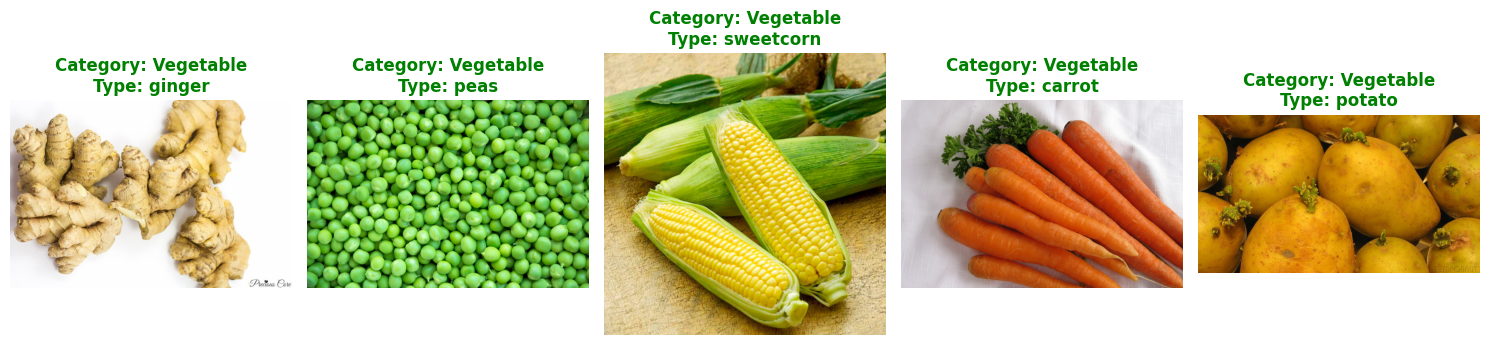

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import torch

# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_multiple_images_svm(num_images=5):
    """
    Picks 'num_images' random samples, predicts them using the HIERARCHICAL SVM,
    and displays them in a row.
    """
    
    # 1. Pick random indices
    total_images = len(test_dataset_stage1)
    indices = random.sample(range(total_images), num_images)
    
    # 2. Setup the Plot Grid
    plt.figure(figsize=(15, 5)) 
    
    print(f"Testing {num_images} random images with SVM...\n")

    for i, idx in enumerate(indices):
        # --- A. Get Data ---
        path, _ = test_dataset_stage1.samples[idx]
        img_tensor, _ = test_dataset_stage1[idx]
        
        # --- B. Prediction Logic ---
        
        input_tensor = img_tensor.unsqueeze(0).to(device)
        
        # 1. MobileNet Features
        with torch.no_grad():
            raw_feat = feature_extractor(input_tensor).view(1, -1).cpu().numpy()
            
        # 2. Parent Decision (SVM)
        parent_pred = stage1_clf.predict(raw_feat)[0]
        
        cat = ""
        pred_type = ""
        
        if parent_pred == 0:
            cat = "Fruit"
            # 3. Child Decision (Fruit SVM)
            # We DID use PCA for the children, so keep this:
            child_feat = pca_fruit.transform(raw_feat)
            local_id = fruit_clf.predict(child_feat)[0]
            pred_type = train_dataset_fruits.classes[local_id]
        else:
            cat = "Vegetable"
            # 3. Child Decision (Veg SVM)
            child_feat = pca_veg.transform(raw_feat)
            local_id = veg_clf.predict(child_feat)[0]
            pred_type = train_dataset_vegs.classes[local_id]

        # --- C. Display ---
        ax = plt.subplot(1, num_images, i + 1)
        
        img_display = Image.open(path)
        plt.imshow(img_display)
        plt.axis('off')
        
        label_text = f"Category: {cat}\nType: {pred_type}"
        
        true_name = os.path.basename(os.path.dirname(path))
        color = 'green' if pred_type == true_name else 'red'
        
        plt.title(label_text, fontsize=12, color=color, fontweight='bold')

    plt.tight_layout()
    plt.show()

# -------------------- Run It for SVM --------------------
test_multiple_images_svm(num_images=5)

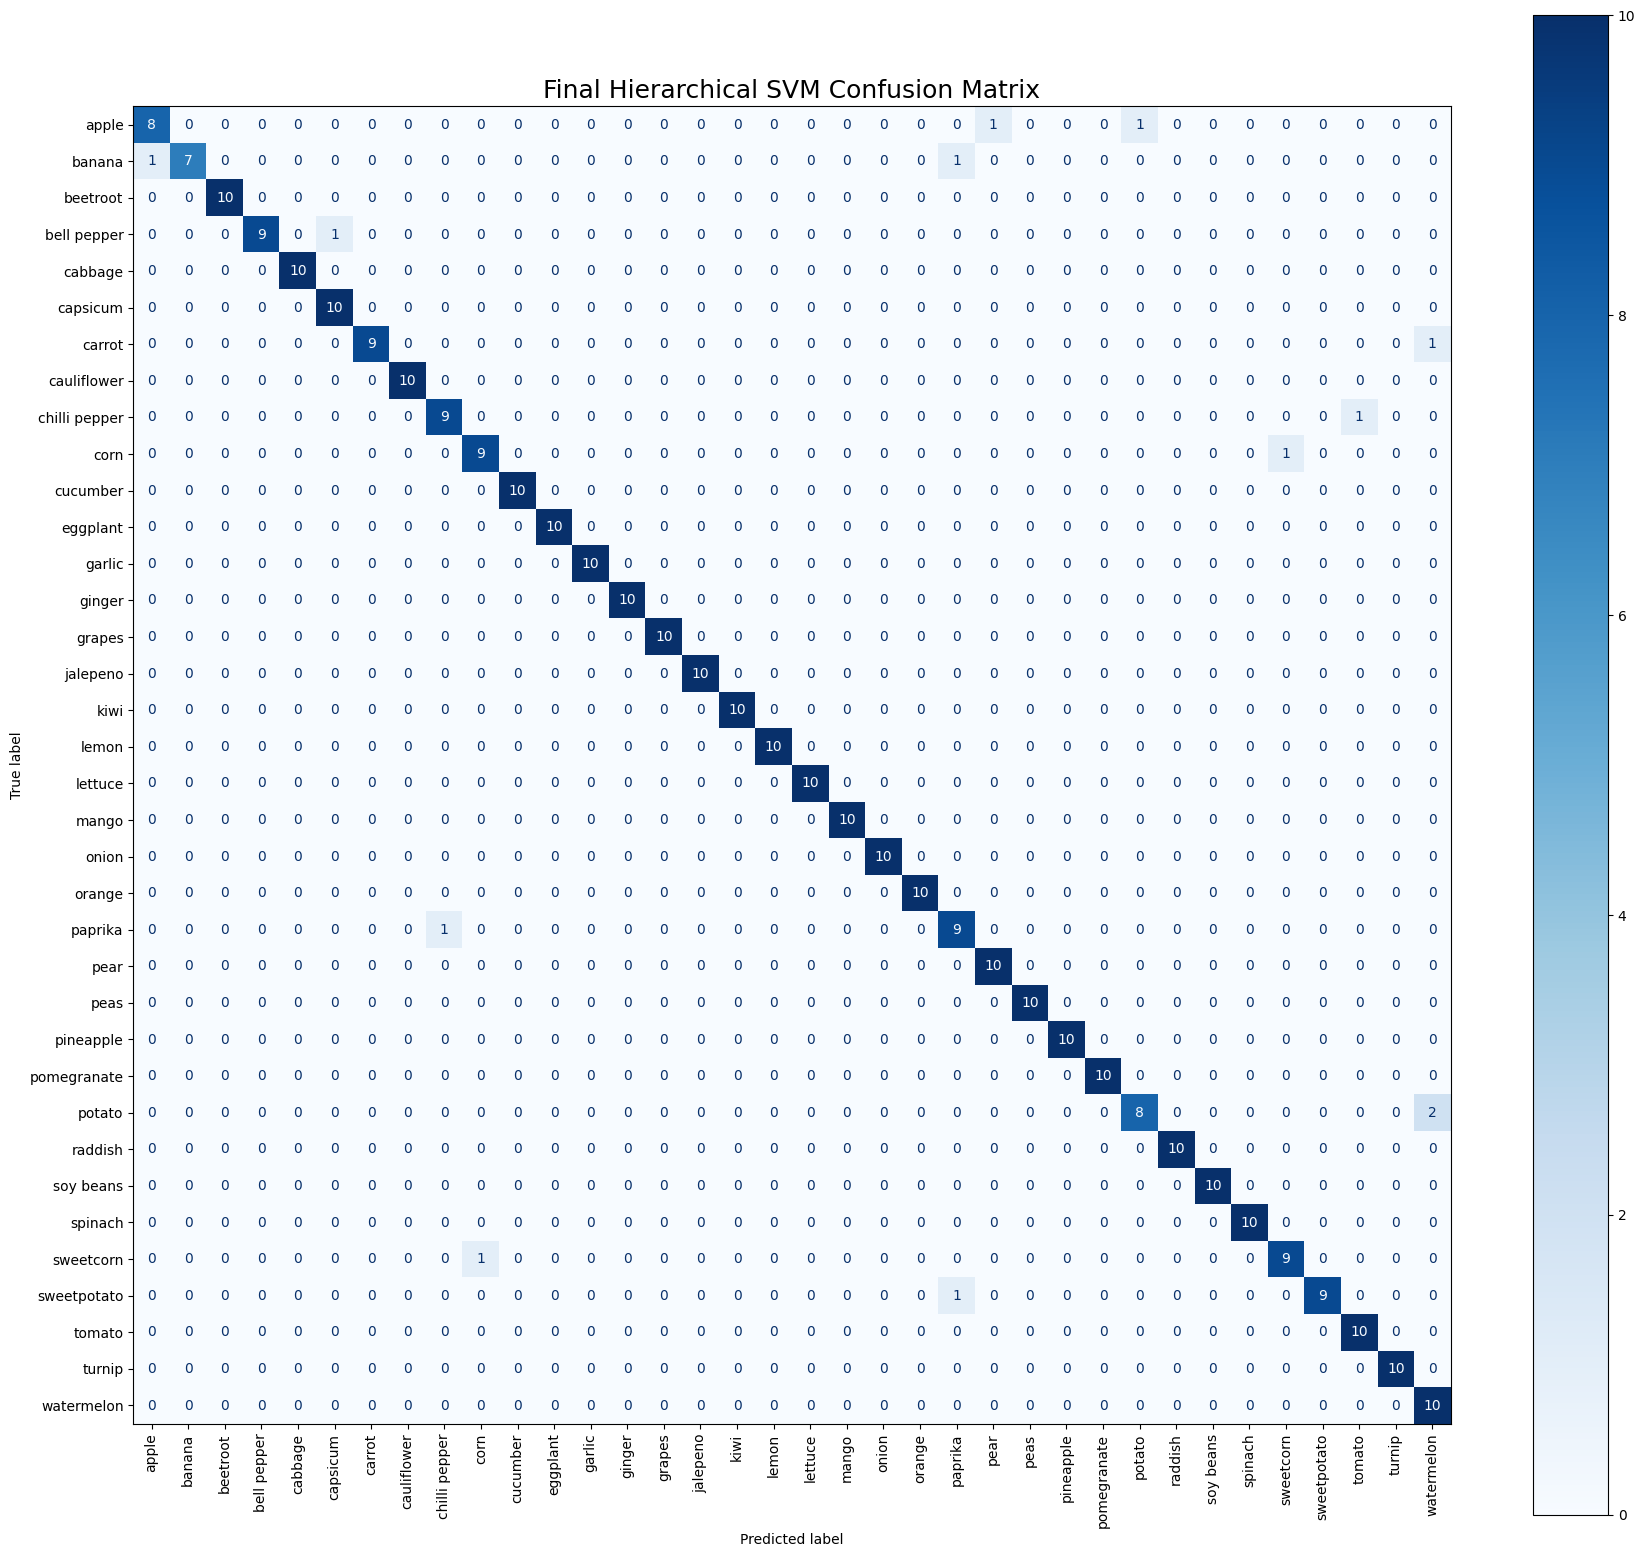

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------- Plot Hierarchical SVM Confusion Matrix --------------------

def plot_confusion_matrix_svm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(18, 16))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )

    disp.plot(
        ax=ax,
        cmap="Blues",
        xticks_rotation=90,
        values_format="d"
    )

    ax.set_title("Final Hierarchical SVM Confusion Matrix", fontsize=18)
    plt.tight_layout()
    plt.show()


# -------- CALL IT --------
plot_confusion_matrix_svm(
    y_true=y_true,
    y_pred=y_pred,
    class_names=all_classes
)